This follows the PyEmma 04-MSM Analysis tutorial (http://www.emma-project.org/latest/tutorials/notebooks/04-msm-analysis.html), updated for `deeptime`.  From that tutorial:

> In this notebook, we will cover how to analyze an MSM and how the modeled processes correspond to MSM spectral properties. We assume that you are familiar with data loading/visualization (Notebook 01 ➜ 📓), dimension reduction (Notebook 02 ➜ 📓), and the estimation and validation process (Notebook 03 ➜ 📓).


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
import deeptime

Once again, we start with the 2D toy model. From the PyEmma tutorial:
> ## Case 1: preprocessed, two-dimensional data (toy model)

> We load the two-dimensional trajectory from an archive using numpy, directly discretize the full space using k
-means clustering, visualize the marginal and joint distributions of both components as well as the cluster centers, and show the implied timescale (ITS) convergence:

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Text(0, 0.5, 'timescale (steps)')

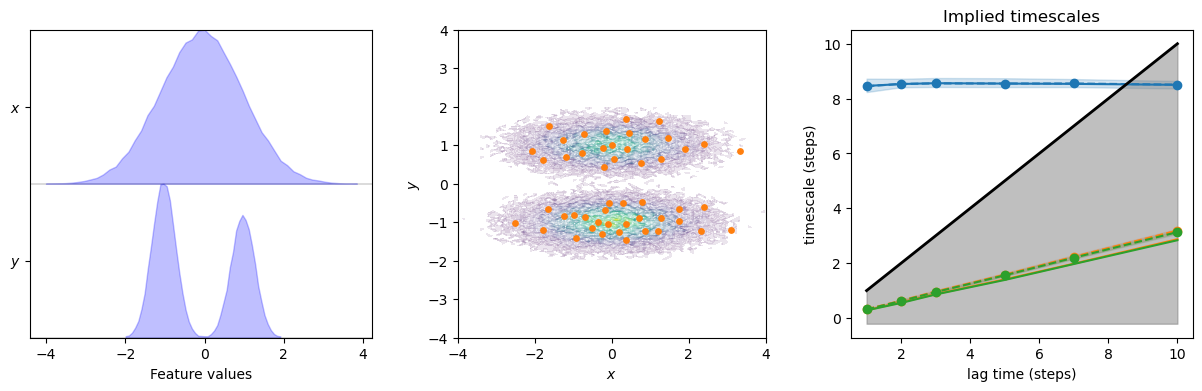

In [2]:
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans
from deeptime.plots import plot_implied_timescales
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

estimator = KMeans(
    n_clusters=50,  # place 50 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(data).fetch_model()
assignments = clustering.transform(data)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')

models = []
lagtimes = [1, 2, 3, 5, 7, 10]
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

plot_implied_timescales(its_data, n_its=3, ax=axes[2])

axes[2].set_title('Implied timescales')
axes[2].set_xlabel('lag time (steps)')
axes[2].set_ylabel('timescale (steps)')


From the PyEmma tutorial:
> The plots show us the marginal (left panel) and joint distributions along with the cluster centers (middle panel). The implied timescales are converged (right panel).

> Before we proceed, let’s have a look at the implied timescales error bars.

These error bars were computed from a Bayesian MSM, which we did by explicitly fitting a `BayesianMSM` object.
From the PyEmma tutoria:

> As mentioned before, Bayesian MSMs incorporate a sample of transition matrices. Target properties such as implied timescales can now simply be computed from the individual matrices. Thereby, the posterior distributions of these properties can be estimated. The ITS plot shows a confidence interval that contains 95% of the Bayesian samples.

In [3]:
counts = TransitionCountEstimator(lagtime=1, count_mode='effective').fit_fetch(assignments)
bayesian_msm = BayesianMSM(n_samples=100).fit_fetch(counts)

We want to take a look at the implied timescale mean and the confidence interval. To do this we are going to use the `gather_stats` function, which will sample from the Bayesian MSM:

In [4]:
help(bayesian_msm.gather_stats)

Help on method gather_stats in module deeptime.base:

gather_stats(quantity, store_samples=False, delimiter='/', confidence=0.95, *args, **kwargs) method of deeptime.markov._base.BayesianMSMPosterior instance
    Obtain statistics about a sampled quantity. Can also be a chained call, separated by the delimiter.
    
    Parameters
    ----------
    quantity: str
        name of attribute, which will be evaluated on samples
    store_samples: bool, optional, default=False
        whether to store the samples (array).
    delimiter : str, optional, default='/'
        separator to call members of members
    confidence : float, optional, default=0.95
        Size of the confidence intervals.
    *args
        pass-through
    **kwargs
        pass-through
    
    Returns
    -------
    statistics : deeptime.util.QuantityStatistics
        The statistics



If we gather stats on the timescales specifically, we will get associated timescales for all the 100 models and we can get their statistics quite easily:

In [5]:
help(bayesian_msm.gather_stats('timescales'))

Help on QuantityStatistics in module deeptime.util.stats object:

class QuantityStatistics(builtins.object)
 |  QuantityStatistics(samples: List[numpy.ndarray], quantity, confidence=0.95, store_samples=False)
 |  
 |  Container for statistical quantities computed on samples.
 |  
 |  Parameters
 |  ----------
 |  samples: list of ndarrays
 |      the samples
 |  store_samples: bool, default=False
 |      whether to store the samples (array).
 |  
 |  Methods defined here:
 |  
 |  __init__(self, samples: List[numpy.ndarray], quantity, confidence=0.95, store_samples=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  gather(samples, quantity=None, store_samples=False, delimiter='/', confidence: float = 0.95, *args, **kwargs)
 |      Obtain statistics about a sampled quantity. Can also be a cha

In [6]:
bmsm_stats =bayesian_msm.gather_stats('timescales',store_samples=True)

In [7]:
bmsm_stats.samples

array([[8.43497419, 0.33064159, 0.31889176, ..., 0.15196382, 0.12254379,
        0.11871305],
       [8.30280765, 0.32707061, 0.31450965, ..., 0.1689772 , 0.15655189,
        0.12273313],
       [8.51738615, 0.32130236, 0.31605219, ..., 0.14632802, 0.14282469,
        0.13251497],
       ...,
       [8.53912248, 0.32004417, 0.31526319, ..., 0.14687984, 0.14633833,
        0.13870782],
       [8.35385381, 0.31673977, 0.31243215, ..., 0.16067317, 0.1539941 ,
        0.13029058],
       [8.47293528, 0.32745431, 0.31027035, ..., 0.16334921, 0.14563166,
        0.11619706]])

In [8]:
bmsm_stats.samples.shape

(100, 49)

Because there are 100 models and each has 49 ITS's, but we only care about the first 1.

In [9]:
sample_mean = bmsm_stats.mean
sample_conf_l = bmsm_stats.L
sample_conf_r = bmsm_stats.R

print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0],sample_conf_r[0]))

Mean of first ITS: 8.466908
Confidence interval: [8.287380, 8.658662]


From the PyEmma tutorial:
> Please note that sample mean and maximum likelihood estimates are not identical and generally do not provide numerically identical results.

> Now, for the sake of simplicity we proceed with the analysis of a maximum likelihood MSM. We estimate it at lag time 1 step…

In [28]:
import deeptime.markov as markov
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible = True,
    stationary_distribution_constraint = None,
    allow_disconnected = True
)
msm = estimator.fit(counts).fetch_model()

> … and check for disconnectivity. The MSM is constructed on the largest set of discrete states that are (reversibly) connected. 

In [11]:
msm.n_connected_msms

1

There is only one connected MSM in this model, so there are no disconnected states.  Let's take a quick break to look at what happens if we DO have disconnected states (this is from the `deeptime` documentation https://deeptime-ml.github.io/latest/api/generated/deeptime.markov.msm.MaximumLikelihoodMSM.html#deeptime.markov.msm.MaximumLikelihoodMSM):

> This example is demonstrating how to fit a Markov state model collection from data which decomposes into a collection of two sets of states with corresponding transition matrices.

In [12]:
from deeptime.markov.msm import MarkovStateModel  # import MSM
msm1 = MarkovStateModel([[.7, .3], [.3, .7]])  # create first MSM
msm2 = MarkovStateModel([[.9, .05, .05], [.3, .6, .1], [.1, .1, .8]])  # create second MSM

> Now, simulate a trajectory where the states of msm2 are shifted by a fixed number 2, i.e., msm1 describes states [0, 1] and msm2 describes states [2, 3, 4] in the generated trajectory.

In [13]:
traj = np.concatenate([msm1.simulate(1000000), 2 + msm2.simulate(1000000)])  # simulate trajectory

Given the trajectory, we fit a collection of MSMs:

In [14]:
model = markov.msm.MaximumLikelihoodMSM(reversible=True).fit(traj, lagtime=1).fetch_model()
model.n_connected_msms

2

> The model behaves like a MSM on the largest connected set, but the behavior can be changed by selecting, e.g., the second largest connected set:

In [15]:
print(model.state_symbols())
model.select(1)  # change to second largest connected set
print(model.state_symbols())

[2 3 4]
[0 1]


Therefore, we can find the fraction of states associated with each connected set by going back to the trajectory and checking for which states are labeled according to the state symbols of that particular connected set in the MSM.

In [16]:
for subi in range(model.n_connected_msms):
    model.select(subi)
    fracstates = 0
    for symbi in model.state_symbols():
        fracstates += len(np.where(traj==symbi)[0])
    print("Fraction of states in model {0} is {1}".format(subi,fracstates/len(traj)))

Fraction of states in model 0 is 0.5
Fraction of states in model 1 is 0.5


Which of course we know to be correct because that's how many we simulated! This would also allow us to find the indices of the active states.

Moving back to our toy model `msm` we want to extract the stationary distribution, which in `deeptime` can be accessed, conveniently, as the `stationary_distribution` attribute.

In [17]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.stationary_distribution.sum()))

[0.03134197 0.03498199 0.01574306 0.02299503 0.03089427 0.01455258
 0.01481875 0.04007109 0.02627011 0.00831972 0.034853   0.03355889
 0.02337096 0.01388869 0.03341198 0.01760547 0.03326995 0.01107162
 0.02554967 0.03475111 0.00856918 0.02262043 0.01631914 0.00555422
 0.02915869 0.01108333 0.02460605 0.0259341  0.02540447 0.00983903
 0.0013095  0.02405204 0.01714162 0.01059234 0.01793778 0.02749371
 0.00617768 0.01982781 0.02354534 0.01925071 0.02095774 0.00800009
 0.00244876 0.02697254 0.01706495 0.01841489 0.00710108 0.02508956
 0.00459801 0.0216153 ]
sum of weights = 1.000000


From the PyEmma tutorial, 

>The attribute `msm.stationary_distribution` tells us, for each discrete state, the absolute probability of observing said state in global equilibrium. Mathematically speaking, the stationary distribution $\pi$ is the left eigenvector of the transition matrix $\mathbf{P}$ to the eigenvalue $1$:

> $\pi^T\mathbf{P} = \pi^T$

> Please note that the $\pi$ is fundamentally different from a normalized histogram of states: for the histogram of states to accurately describe the stationary distribution, the data needs to be sampled from global equilibrium, i.e, the data points need to be statistically independent. The MSM approach, on the other hand, only requires local equilibrium, i.e., statistical independence of state transitions. Thus, the MSM approach requires a much weaker and, in practice, much easier to satisfy condition than simply counting state visits.

> We can use the stationary distribution to, e.g., visualize the weight of the discrete states and, thus, to highlight which areas of our feature space are most probable. Here, we show all data points in a two dimensional scatter plot and color/weight them according to their discrete state membership:

`deeptime` doesn't seem to have a contour visualization the way PyEmma does, but we can just do a simple scatter-plot that will show us very similar information. I compare the two ways of looking at this below:

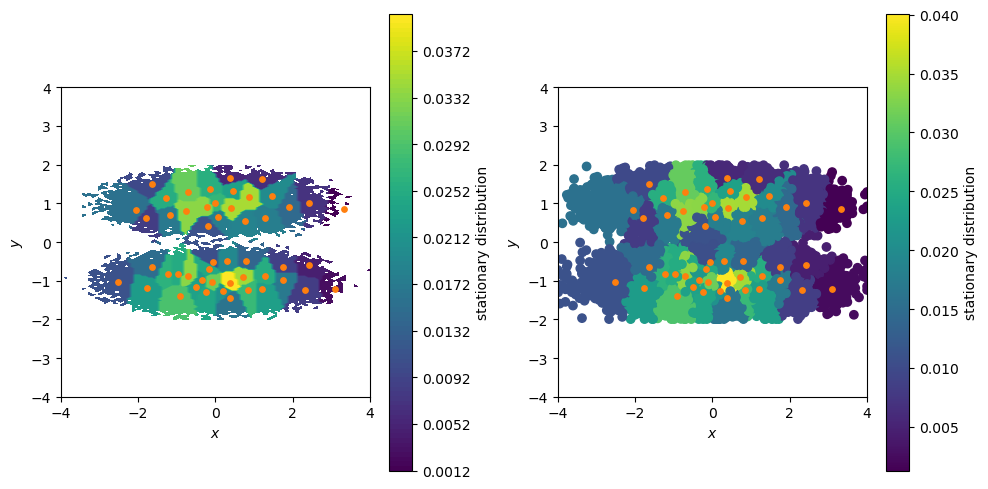

In [18]:
fig,axes= plt.subplots(1,2,figsize=(10,5))
pyemma.plots.plot_contour(
    *data.T, msm.stationary_distribution[assignments],
    cbar_label='stationary distribution',
    method='nearest', mask=True,ax=axes[0])
axes[0].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')
sp=axes[1].scatter(*data.T,c=msm.stationary_distribution[assignments])
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.colorbar(sp,ax=axes[1],label='stationary distribution')
fig.tight_layout()

In the Pyemma case, on the left, we interpolate the contours. On the right, rather than interpolating, we simply show every state along with its probability in the stationary distribution.

Moving onward, from the PyEmma tutorial, 
> The stationary distribution can also be used to correct the pyemma.plots.plot_free_energy() function that we used to visualize this dataset in Notebook 01 ➜ 📓. This might be necessary if the data points are not sampled from global equilibrium.

>In this case, we assign the weight of the corresponding discrete state to each data point and pass this information to the plotting function via its `weights` parameter:

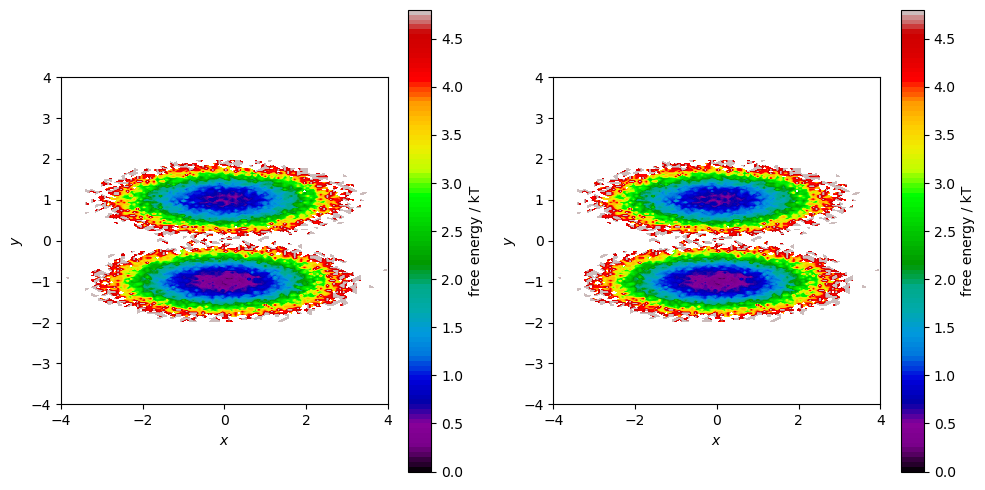

In [36]:
fig,axes= plt.subplots(1,2,figsize=(10,5))
pyemma.plots.plot_free_energy(
    *data.T,
    legacy=False,ax=axes[0])
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')

pyemma.plots.plot_free_energy(
    *data.T,
    weights=np.concatenate(msm.compute_trajectory_weights(assignments)),
    legacy=False,ax=axes[1])
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

In this case, we note that the reweighting has really not done anything, but it might be more useful under other circumstances (ie the points are not sampled from global equilibrium, as mentioned in the PyEmma tutorial). Continuing with the tutorial...

> We will see further uses of the stationary distribution later. But for now, we continue the analysis of our model by visualizing its (right) eigenvectors which encode the dynamical processes. First, we notice that the first right eigenvector is a constant 1.

We can grab the eigenvectors of the matrix, which describe transitions between all fifty microstates, the same way in deeptime as we do in PyEmma

In [40]:
msm.eigenvectors_right().shape

(50, 50)

In [41]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: True (min=0.9999999999999967, max=1.000000000000003)


From the PyEmma tutorial, 

> The right eigenvectors can be used to visualize the processes governed by the corresponding implied timescales. The first right eigenvector (always) is $(1,…,1)^⊤$ for an MSM transition matrix and it corresponds to the stationary process (infinite implied timescale).

> The second right eigenvector corresponds to the slowest process; its entries are negative for one group of discrete states and positive for the other group. This tells us that the slowest process happens between these two groups and that the process relaxes on the slowest ITS (≈8.5 steps).

> The third and fourth eigenvectors show a larger spread of values and no clear grouping. In combination with the ITS convergence plot, we can safely assume that these eigenvectors contain just noise and do not indicate any resolved processes.

In specific, we are plotting $\psi(s_i)$, where $\psi$ is the eigenvector and it is a function of the state $s_i$ which is given by checking the `assignments` variable.

In [46]:
eigvec[assignments,1]

array([-0.8961187 , -0.88397766, -0.88815745, ..., -0.89013729,
       -0.87752212, -0.88872807])

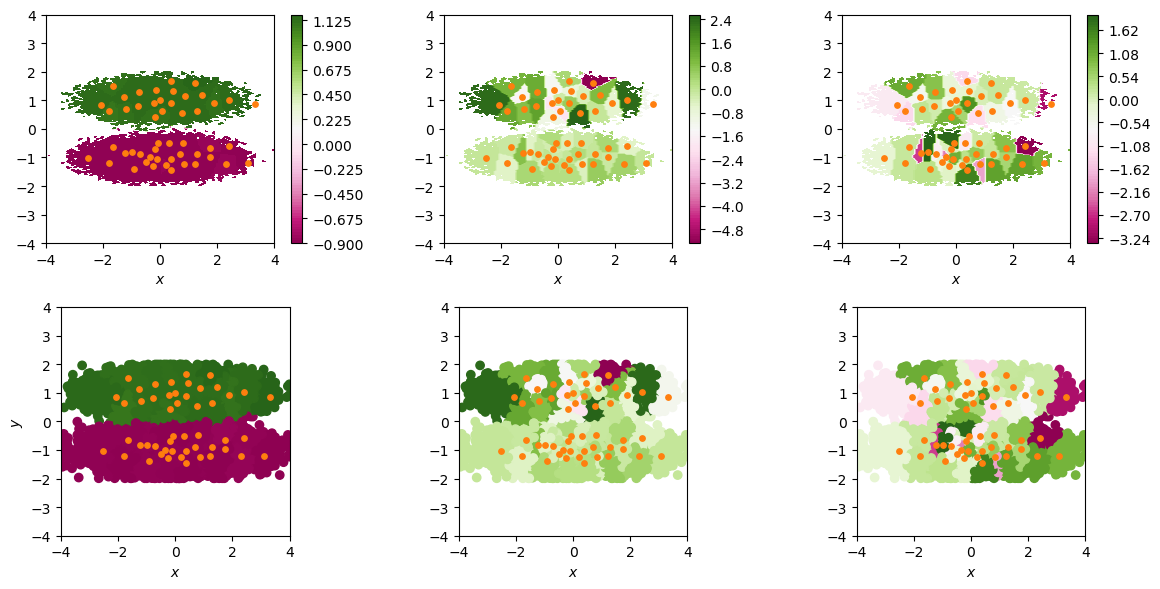

In [59]:
diminvs = 3
fig, axes = plt.subplots(2,diminvs,figsize=(12,6))
for i in range(diminvs):
    pyemma.plots.plot_contour(
        *data.T, eigvec[assignments,i+1], ax=axes[0,i], cmap = 'PiYG',
        cbar_labels='{}. right eigenvector'.format(i+2),mask=True)
    axes[0,i].scatter(*(clustering.cluster_centers.T),s=15,c='C1')
    axes[0,i].set_xlabel('$x$')
    axes[0,i].set_xlim(-4, 4)
    axes[0,i].set_ylim(-4, 4)
    axes[0,i].set_aspect('equal')
    
for i in range(diminvs):
    axes[1,i].scatter(
        *data.T, c=eigvec[assignments,i+1], cmap = 'PiYG')
    axes[1,i].scatter(*(clustering.cluster_centers.T),s=15,c='C1')
    axes[1,i].set_xlabel('$x$')
    axes[1,i].set_xlim(-4, 4)
    axes[1,i].set_ylim(-4, 4)
    axes[1,i].set_aspect('equal')

axes[1,0].set_ylabel('$y$')
fig.tight_layout()

From the PyEmma tutorial,
> We then continue to validate our MSM with a CK test for 2 metastable states which are already indicated by the second right eigenvector.

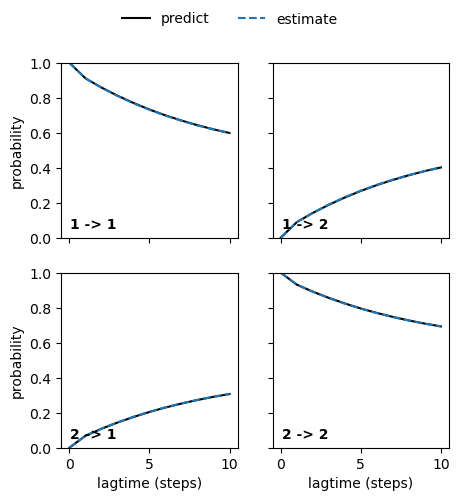

In [65]:
from deeptime.plots.chapman_kolmogorov import plot_ck_test
models = []
for lag in range(1,11):
    counts_estimator = TransitionCountEstimator(lagtime=lag, count_mode='effective')
    models.append(markov.msm.MaximumLikelihoodMSM().fit_fetch(counts_estimator.fit_fetch(assignments)))

ck_test = msm.ck_test(models,n_metastable_sets=2)
grid = plot_ck_test(ck_test,legend=True)

As we can see, comparing the predictions of the model applied for multiple steps to the predictions of other models estimated at longer lag times demonstrates that this model does not fail the CK test and therefore we do not reject its Markovianity.

> We now save the model to do more analyses with PCCA++ and TPT in step4.

In [67]:
import pickle
fold = './data/'
fnames = ['step3-doublewell_cluster.pkl',
          'step3-doublewell_msm.pkl',
          'step3-doublewell_bayesian_msm.pkl']
varlist = [clustering,
           msm,bayesian_msm]
for i in range(len(fnames)):
    f = open(fold+fnames[i],'wb')
    pickle.dump(varlist[i],f)
    f.close()

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)

Following the PyEmma tutorial and what we have done in our previous steps, we will

>  fetch the alanine dipeptide data set, load the backbone torsions into memory, directly discretize the full space using k-means clustering, visualize the margial and joint distributions of both components as well as the cluster centers, and show the ITS convergence to help selecting a suitable lag time:

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\RMANSBAC\Anaconda3\envs\mdlearnenv\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


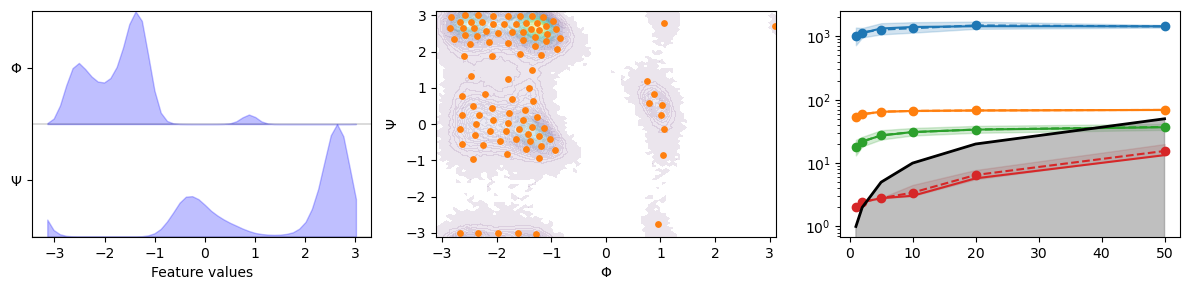

In [69]:
from localfeaturizers import local_dihedral_featurizer
import mdshare
import mdtraj as mdt

pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

trajs = []
for f in files:
    traj = mdt.load(f,top=pdb)
    trajs.append(traj)
    
dihslist = local_dihedral_featurizer(trajs,False,sincos=False,psiphionly=True)

from tqdm.notebook import tqdm
from deeptime.clustering import KMeans

estimator = KMeans(
    n_clusters=100,  # place 50 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=50,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(dihslist).fetch_model()
dtrajs = [clustering.transform(dihslist[i]) for i in range(len(dihslist))]

data_concatenated = np.vstack(dihslist)

models = []
lagtimes = [1, 2, 5, 10, 20, 50]
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(data_concatenated[:,0],data_concatenated[:,1], ax=axes[1],cbar=False,alpha=0.1)
axes[1].scatter(*clustering.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
plot_implied_timescales(its_data, n_its=4, ax=axes[2])
axes[2].set_yscale('log')
fig.tight_layout()

From the PyEmma tutorial, 

> The plots show us the marginal (left panel) and joint distributions along with the cluster centers (middle panel). The implied timescales are converged (right panel).

> We then estimate an MSM at lag time 10 ps and visualize the stationary distribution by coloring all data points according to the stationary weight of the discrete state they belong to:

In [71]:
counts = TransitionCountEstimator(lagtime=10, count_mode='effective').fit_fetch(dtrajs)
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible = True,
    stationary_distribution_constraint = None,
    allow_disconnected = True
)
msm = estimator.fit(counts).fetch_model()

In [72]:
msm.n_connected_msms

1

In [75]:
data_concatenated.shape

(750000, 2)

In [82]:
dtrajs_concatenated = np.concatenate(dtrajs)

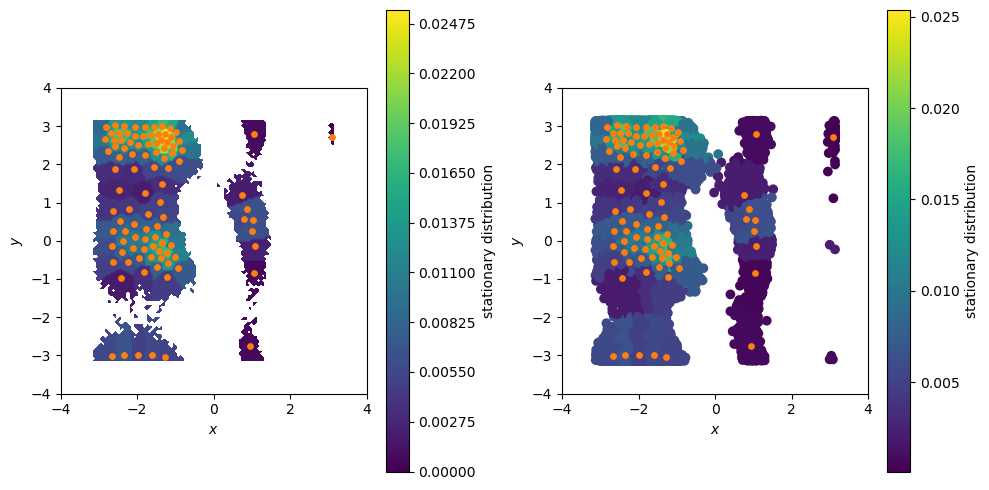

In [83]:
fig,axes= plt.subplots(1,2,figsize=(10,5))
pyemma.plots.plot_contour(
    *data_concatenated.T, msm.stationary_distribution[dtrajs_concatenated],
    cbar_label='stationary distribution',
    method='nearest', mask=True,ax=axes[0])
axes[0].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')
sp=axes[1].scatter(*data_concatenated.T,c=msm.stationary_distribution[dtrajs_concatenated])
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.colorbar(sp,ax=axes[1],label='stationary distribution')
fig.tight_layout()